<a href="https://colab.research.google.com/github/mosamini1/digital_methods/blob/main/trump_tweet_dh_v3_20221222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 - Install all required packages using !pip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install bertopic
!pip install bertopic
!pip install punkt
!pip install stopwords
!pip install pandas
!pip install numpy
!pip install re
!pip install string
!pip install nltk
!pip install sklearn
!pip install emoji
!pip install gensim
!pip install spacy
!pip install seaborn
!pip install plotly


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement punkt (from versions: none)
ERROR: No matching distribution found for punkt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Looking in indexes: https://pypi.or

2 - Download packages specific to nltk; normally we would have to load nltk prior to this, however since these are already installed, no need

In [ ]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


NameError: ignored

3 - Load all packages needed for our analysis

In [ ]:
import pandas as pd
import numpy as np
import bertopic 
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import gensim
import spacy

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Global Parameters
stop_words = set(stopwords.words('english'))

In [ ]:
import seaborn as sns
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk
import plotly

4 - Set out specific preferences and ensure our model is reproducible

In [ ]:
#seaborn options
sns.set_style('white')

#pandas options
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

#Reproducibility!
seed = 42
num_folds = 10
v_size = 0.2
metric = 'accuracy'

#Random seeds
np.random.seed(seed)

5 - Load our Trump data set that is already filtered for between 1/1/2019 and 1/1/2021; filtering conducted in R

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/__Academics/HDS/DIGHUM/tweets_filtered_4_analysis.csv"
                #,encoding = 'latin-1'
                )

In [ ]:
df.head(10)

6 - Make a copy, so our source file is readily available in case we need to start again

In [ ]:
df2 = df.copy()

7 - Drop the columns that we will not be needing

In [ ]:
df2.columns

In [ ]:
toDrop = ['Unnamed: 0', 'id', 'isRetweet', 'isDeleted', 'device',
       'favorites', 'retweets', 'date', 'isFlagged',
       'date_time', 'time']

In [ ]:
df2.drop(toDrop, axis=1, inplace=True)

In [ ]:
df2.head(10)

8 - Remove retweets

In [ ]:
df2=df2[~df2['text'].str.startswith('RT')]

In [ ]:
df2.info()

9 - Convert date field to dtype datetime then extract month

In [ ]:
df2['df_created_at'] = pd.to_datetime(df2['df_created_at'])

In [ ]:
df2.head(5)

In [ ]:
df2['month'] = df2['df_created_at'].dt.to_period('M')

10 - Create a quick bar graph showing the number of tweets across year and month

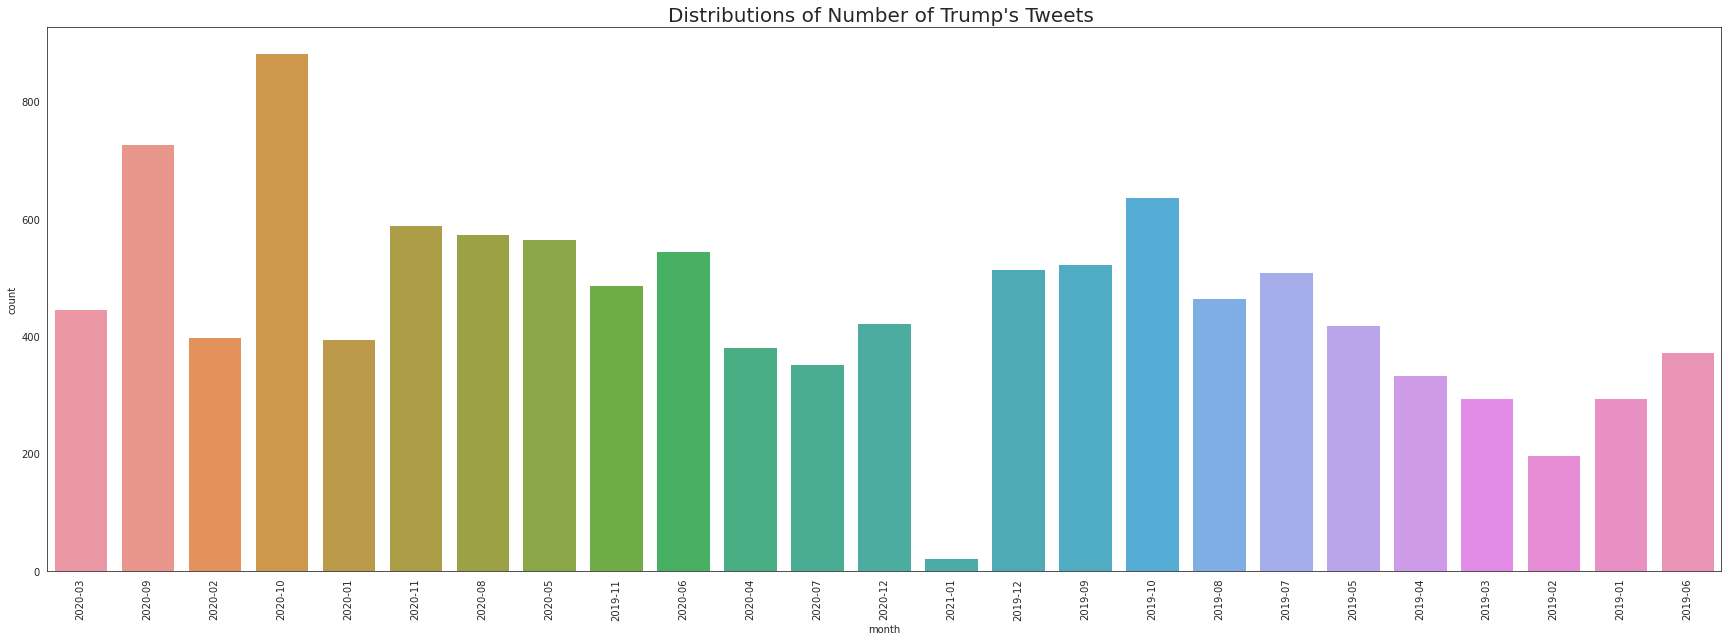

In [ ]:
plt.figure(figsize=(30, 10))
sns.set_style('white')
sns.countplot(x='month', data=df2 )
plt.xticks(rotation = 90)
plt.title("Distributions of Number of Trump's Tweets ", fontsize = 20)
plt.show()

11 - Implement a script to preprocess and normalize tweets, in preparation for nlp topic modeling and analysis

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return ""
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return ""
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [ ]:
import torch
from transformers import AutoTokenizer
#from TweetNormalizer import normalizeTweet
df2['text'] = df2['text'].apply(normalizeTweet)

In [ ]:
df2.head(10)

In [ ]:
df2.info()

12 - Turn all blank rows into NaN and remove

In [ ]:
df2['text'].replace('', np.nan, inplace=True)

In [ ]:
df3 = df2.dropna(how='any',axis=0) 


In [ ]:
df3.head(10)

13 - Additional pre-processing steps 

In [ ]:
#Lower case 
def remove_uppercase(text):
    text_lowercase = ' '.join(x.lower() for x in text.split())# It will discard all uppercases
    return text_lowercase

In [ ]:
df3['text_clean'] = df3['text'].apply(lambda x: remove_uppercase(x))


In [ ]:
df3

In [ ]:
#Function to remove Punctuation
string.punctuation

def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

In [ ]:
df3['text_clean'] = df3['text_clean'].apply(lambda x: remove_punct(x))


14 - Apply tokenization and handle removal

In [ ]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)

In [ ]:
df3['text_clean_token'] = df3['text_clean'].apply(tknzr.tokenize)

In [ ]:
df3

15 - Remove all stopwords

In [ ]:
stopword = nltk.corpus.stopwords.words('english') # All English Stopwords
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]# To remove all stopwords
    return text

In [ ]:
df3['text_clean_token'] = df3['text_clean_token'].apply(lambda x: remove_stopwords(x))

In [ ]:
df3

16 - Apply lemmatization (not using stemming, since the former tends to be more precise, even though it may take up more resources)

In [ ]:
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word,  pos='a') for word in tokenized_text]
    return text

In [ ]:
df3['text_clean_token_lemma'] = df3['text_clean_token'].apply(lambda x: lemmatizing(x))


In [ ]:
df3

17 - Creating another checkpoint by copying over data set

In [ ]:
df4 = df3.copy()

In [ ]:
df4

In [ ]:
df4.columns

In [ ]:
df4.info()

18 - Convert new text field into string

In [ ]:
df4['text_clean_token_lemma'] = df4['text_clean_token_lemma'].astype(str)

19 - Need to reset index, otherwise model will not work

In [ ]:
df4 = df4.reset_index(drop=True)


20 - Set up BERTopic topic model

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

#vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words="english", min_df=5)
topic_model = BERTopic(language="english", 
                       calculate_probabilities=False, 
                       verbose=True,
                       low_memory= True,
                       embedding_model = "paraphrase-MiniLM-L3-v2",
                       #vectorizer_model=vectorizer_model,
                       nr_topics = 53)

In [ ]:
df4

19 - Apply model to data

In [ ]:
#Gived that our dataset is so large, need to implement the following guidance on parameter
#tuning to make sure it runs faster: https://github.com/MaartenGr/BERTopic/issues/151
topics, probs = topic_model.fit_transform(df4.text_clean_token_lemma)

Batches:   0%|          | 0/317 [00:00<?, ?it/s]

2022-12-23 03:50:30,346 - BERTopic - Transformed documents to Embeddings
2022-12-23 03:50:52,551 - BERTopic - Reduced dimensionality
2022-12-23 03:50:53,096 - BERTopic - Clustered reduced embeddings
2022-12-23 03:50:54,574 - BERTopic - Reduced number of topics from 149 to 54


20 - Lets visualize to get some insight into our data

In [ ]:
freq = topic_model.get_topic_info(); freq

,Topic,Count,Name
0,-1,4788,-1_great_nt_president_fake
1,0,338,0_thank_kag_2020_honor
2,1,328,1_endorsement_complete_total_amendment
3,2,310,2_border_wall_southern_mexico
4,3,289,3_ballots_election_rigged_votes
5,4,240,4_biden_joe_sleepy_fracking
6,5,220,5_china_tariffs_deal_trade
7,6,179,6_book_great_congratulations_number
8,7,169,7_honor_god_today_nation
9,8,139,8_mueller_report_collusion_obstruction


22 - Here are a series of visualizations that provide more insight into Trump's tweets. Still trying to derive conclusive thoughts.

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.get_topic(0)

[('thank', 0.44568966633910956),
 ('kag', 0.14971915224284404),
 ('2020', 0.12605096552155792),
 ('honor', 0.06459620926067657),
 ('nice', 0.05632303728829824),
 ('great', 0.044960210476473174),
 ('love', 0.043516230450476284),
 ('working', 0.02951597792371671),
 ('hard', 0.0281620272050619),
 ('dallas', 0.024675182794394714)]

In [ ]:
df4['month'] = df4['month'].astype(datetime)


NameError: ignored

In [ ]:
df4.month


0        1583020800000000000
1        1598918400000000000
2        1580515200000000000
3        1577836800000000000
4        1601510400000000000
                ...         
10119    1575158400000000000
10120    1575158400000000000
10121    1575158400000000000
10122    1601510400000000000
10123    1601510400000000000
Name: month, Length: 10124, dtype: object

In [ ]:
timestamps = df4.month.to_list()
tweets = df4.text_clean_token_lemma.to_list()

In [ ]:
df4.month = pd.to_numeric(pd.to_datetime(df4.month))

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10124 entries, 0 to 10123
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    10124 non-null  object
 1   df_created_at           10124 non-null  object
 2   month                   10124 non-null  object
 3   text_clean              10124 non-null  object
 4   text_clean_token        10124 non-null  object
 5   text_clean_token_lemma  10124 non-null  object
dtypes: object(6)
memory usage: 474.7+ KB


In [ ]:
timestamps2 = list(set(timestamps))

In [ ]:
topics_over_time = topic_model.topics_over_time(tweets, topics, timestamps)

ValueError: ignored

In [ ]:
topic_model.visualize_topics_over_time(
    topics_over_time 
   # ,top_n_topics=50
    )


NameError: ignored

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_barchart(top_n_topics=50)

In [ ]:
topic_model.visualize_term_rank()